## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## Libraries

In [2]:
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt

#Text Color
from termcolor import colored

#Train Test Split
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

## Data Preprocessing

In [3]:
#File Path
TRAIN_FILE_PATH = '/content/MyDrive/MyDrive/Data Science/Projects/SpoonShot/train.csv'
TEST_FILE_PATH = '/content/MyDrive/MyDrive/Data Science/Projects/SpoonShot/test.csv'

#Load Data
data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

#Set Column Names 
data.columns = ['ClassIndex', 'Title', 'Description']
testdata.columns = ['ClassIndex', 'Title', 'Description']

#Combine Title and Description
X_train = data['Title'] + " " + data['Description'] # Combine title and description (better accuracy than using them as separate features)
y_train = data['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

x_test = testdata['Title'] + " " + testdata['Description'] # Combine title and description (better accuracy than using them as separate features)
y_test = testdata['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

#Max Length of sentences in Train Dataset
maxlen = X_train.map(lambda x: len(x.split())).max()
data.head()

,ClassIndex,Title,Description
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
2,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
3,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
4,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...


## Exploratory Data Analysis

### Data Shape

In [40]:
data.shape, testdata.shape

((119999, 3), (7599, 3))

### Value Counts

In [42]:
#Checking Value counts to determine class balance
data.ClassIndex.value_counts()

4    30000
2    30000
1    30000
3    29999
Name: ClassIndex, dtype: int64

In [4]:
testdata.ClassIndex.value_counts()

2    1900
1    1900
4    1900
3    1899
Name: ClassIndex, dtype: int64

### Null Values

In [5]:
#Train Data
data.isnull().sum()

ClassIndex     0
Title          0
Description    0
dtype: int64

In [6]:
#Test Data
testdata.isnull().sum()

ClassIndex     0
Title          0
Description    0
dtype: int64

## Tokenize and Pad Data

In [8]:
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

# Tokenize data
X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(x_test)

# Pad data
X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

## Model

**BiDirectional LSTM** - Using bidirectional will run our inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards we preserve information from the future and using the two hidden states combined we are able in any point in time to preserve information from both past and future.

In [9]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 177, 32)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 177, 256)          164864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 177, 128)          164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

## Compile and Fit Model

In [10]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [11]:
#Compile and Fit Model

model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, 
          y_train, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          epochs=20, 
          callbacks=callbacks)

Epoch 1/20
469/469 [==============================] - 51s 84ms/step - loss: 0.6287 - accuracy: 0.7316 - val_loss: 0.2665 - val_accuracy: 0.9130

Epoch 00001: val_accuracy improved from -inf to 0.91301, saving model to weights.h5
Epoch 2/20
469/469 [==============================] - 39s 83ms/step - loss: 0.2297 - accuracy: 0.9258 - val_loss: 0.2706 - val_accuracy: 0.9113

Epoch 00002: val_accuracy did not improve from 0.91301
Epoch 3/20
469/469 [==============================] - 39s 83ms/step - loss: 0.1879 - accuracy: 0.9379 - val_loss: 0.2643 - val_accuracy: 0.9114

Epoch 00003: val_accuracy did not improve from 0.91301
Epoch 4/20
469/469 [==============================] - 39s 83ms/step - loss: 0.1582 - accuracy: 0.9476 - val_loss: 0.2813 - val_accuracy: 0.9139

Epoch 00004: val_accuracy improved from 0.91301 to 0.91394, saving model to weights.h5
Epoch 5/20
469/469 [==============================] - 39s 83ms/step - loss: 0.1268 - accuracy: 0.9558 - val_loss: 0.3234 - val_accuracy: 0.

## Load Weights with Best val Accuracy

In [12]:
model.load_weights('weights.h5')
model.save('model.hdf5')

## Model Demo

In [24]:
def modelDemo(news_text):

  #News Labels
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

  test_seq = pad_sequences(tok.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))


In [26]:
modelDemo(['New evidence of virus risks from wildlife trade'])

New evidence of virus risks from wildlife trade - Science-Technology News


In [27]:
modelDemo(['Coronavirus: Bank pumps £100bn into UK economy to aid recovery'])

Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News


In [28]:
modelDemo(['Trump\'s bid to end Obama-era immigration policy ruled unlawful'])

Trump's bid to end Obama-era immigration policy ruled unlawful - World News


In [29]:
modelDemo(['David Luiz’s future with Arsenal to be decided this week'])

David Luiz’s future with Arsenal to be decided this week - Sports News


In [30]:
modelDemo(['Indian Economic budget supports the underprivileged sections of society'])

Indian Economic budget supports the underprivileged sections of society - Business News


## Model Evaluation

### Confusion Matrix

<Figure size 432x288 with 0 Axes>

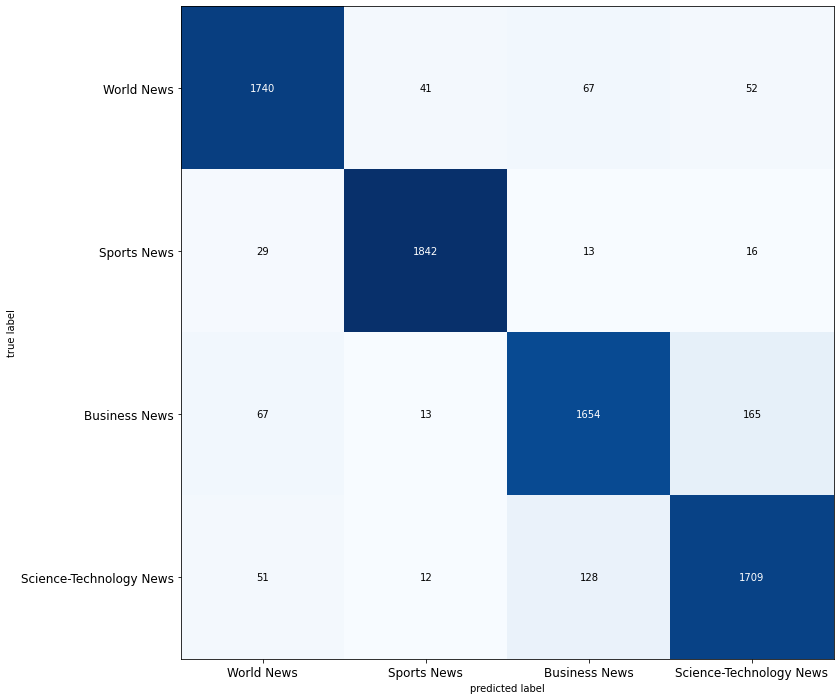

In [31]:
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

### Recall, Precision and Accuracy

In [32]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.91
Precision of the model is 0.91
Accuracy of the model is 0.91
